In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 99% !important;}</style>"))

In [2]:
import numpy   as np
import scipy   as sp
import pandas  as pd
import seaborn as sns
import matplotlib
import kabuki
from matplotlib import pyplot as plt
import ipyparallel
from ipyparallel import parallel
import hddm
import os

%matplotlib inline
np.set_printoptions(suppress = True)

/Users/user/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/user/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/user/anaconda/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [20]:
os.chdir("/Users/user/Desktop/Experiments/Nick/AttentionSaccade")
sublist = [1,2,3,4,5,6,7,8,9]

datafname = os.path.join(os.getcwd(), 'AttentionSaccade_BehaviouralData_All.csv')
data = pd.read_csv(datafname, sep = ',', index_col = False) #read in collated data
data = data.drop(data.columns[0], axis = 1) #drop unnamed, random column that has appeared in the data
attention = data.loc[data['task']==1]
saccade   = data.loc[data['task']==2]
attention.columns

Index([u'subject', u'session', u'trial', u'task', u'cuecol', u'cueloc',
       u'validity', u'targloc', u'targtilt', u'delay', u'resp', u'time',
       u'corr'],
      dtype='object')

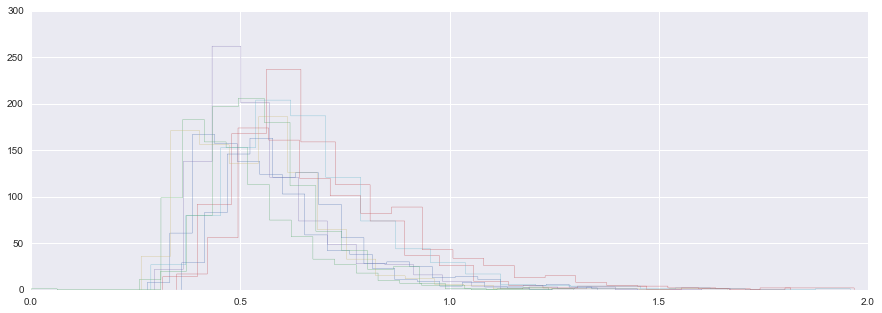

In [21]:
plt.rcParams['figure.figsize'] = (15,5)
for i, subject in attention.groupby('subject'):
    subject.time.hist(bins = 20, histtype = 'step')

In [22]:
attention = attention[['subject', 'time', 'corr', 'validity']] #select dataframe down to just these variables
attention = attention.rename(columns={'time':'rt', "corr":'response','subject':'subj_idx'}) #rename for use with hddm package
attention = attention[np.isnan(attention['rt'])==False] #remove trials with no response

attval = attention[attention['validity']==1]
attinv = attention[attention['validity']==0]
print attval.shape, attinv.shape
#attention.shape
#attention = attention[attention['rt']<0.05]
#np.where(np.isnan(attention['rt'])) #check for missing data

(6891, 4) (1721, 4)


In [23]:
modelvalid = hddm.HDDM(data = attval, p_outlier=0.05, bias = True)
modelvalid.find_starting_values()
modelvalid.sample(2000, burn = 20)

/Users/user/anaconda/lib/python2.7/site-packages/scipy/optimize/optimize.py:1876: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/user/anaconda/lib/python2.7/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 2000 of 2000 complete in 116.6 sec

In [24]:
modelinv = hddm.HDDM(data=attinv, p_outlier=0.05, bias = True)
modelinv.find_starting_values()
modelinv.sample(2000, burn = 20)

 [-----------------100%-----------------] 2000 of 2000 complete in 50.4 sec

In [28]:
stats_valid = modelvalid.gen_stats()
stats_valid[stats_valid.index.isin(['a', 'a_std', 'v','v_std', 't', 't_std', 'z', 'z_std'])]

# a, v, t, z parameters for each participant, and the group (mean + stds)
# a = decision threshold
# v = drift rate
# t = non-decision time parameter
# z = prepotent response bias
#stats[stats.index.isin(['a', 'a_std', 'a_subj.0', 'a_subj.1'])]

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,1.24295,0.0379157,1.17085,1.21895,1.24206,1.26591,1.32282,0.00111725
a_std,0.107024,0.0353775,0.0592657,0.0827088,0.100279,0.124605,0.190332,0.00134602
v,2.09739,0.266093,1.56379,1.9425,2.09631,2.2562,2.6281,0.00660777
v_std,0.74673,0.223533,0.438343,0.588424,0.700703,0.861683,1.2912,0.00657652
t,0.318605,0.0184134,0.284963,0.307041,0.317409,0.328845,0.360839,0.000461555
t_std,0.0518166,0.0181079,0.0296943,0.0398733,0.0475451,0.0595228,0.0986729,0.000627947
z,0.461092,0.0131184,0.435432,0.452351,0.46089,0.469568,0.487277,0.000484307
z_std,0.135423,0.0253322,0.0868983,0.117961,0.134339,0.152141,0.187506,0.00114448


In [29]:
stats_invalid = modelinv.gen_stats()
stats_invalid[stats_invalid.index.isin(['a', 'a_std', 'v','v_std', 't', 't_std', 'z', 'z_std'])]


,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,1.16845,0.0598583,1.0551,1.13016,1.16612,1.20349,1.29524,0.00176548
a_std,0.16329,0.0560511,0.0858948,0.123924,0.152971,0.191291,0.305952,0.00235452
v,1.25356,0.165412,0.930334,1.1576,1.2518,1.35284,1.5794,0.00606684
v_std,0.405667,0.169664,0.188795,0.29284,0.372318,0.477606,0.825919,0.00724764
t,0.43127,0.0324741,0.371964,0.410951,0.429317,0.448738,0.504314,0.0011095
t_std,0.0880853,0.0327315,0.0507206,0.0667937,0.0807208,0.100414,0.170466,0.00147314
z,0.505085,0.0137515,0.478159,0.496564,0.504213,0.513647,0.533257,0.000801377
z_std,0.0851769,0.0423677,0.000952372,0.0604012,0.089695,0.114817,0.160755,0.00343343


Plotting a
Plotting a_std
Plotting v
Plotting t


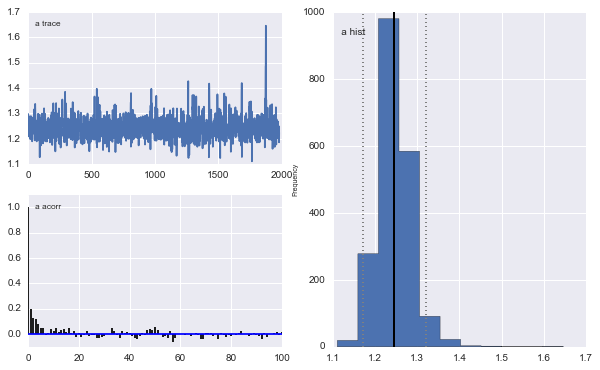

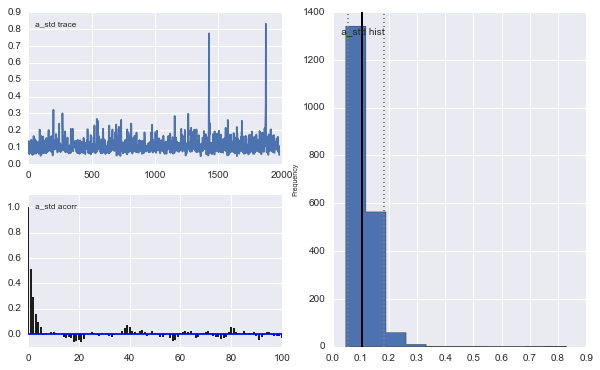

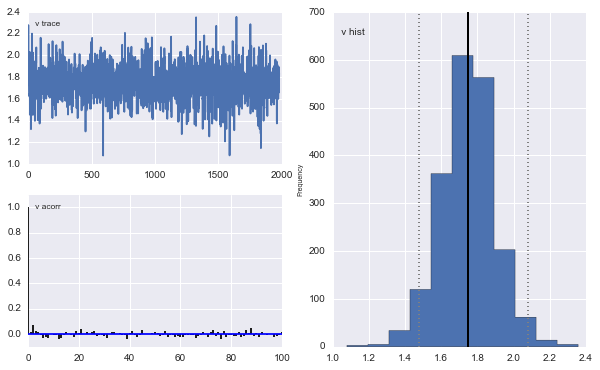

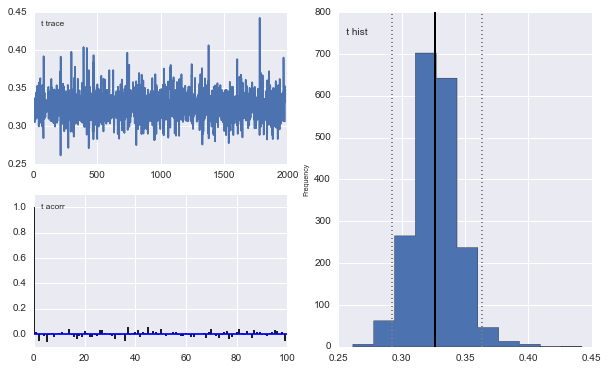

In [111]:
model.plot_posteriors(['a', 't', 'v', 'a_std'])

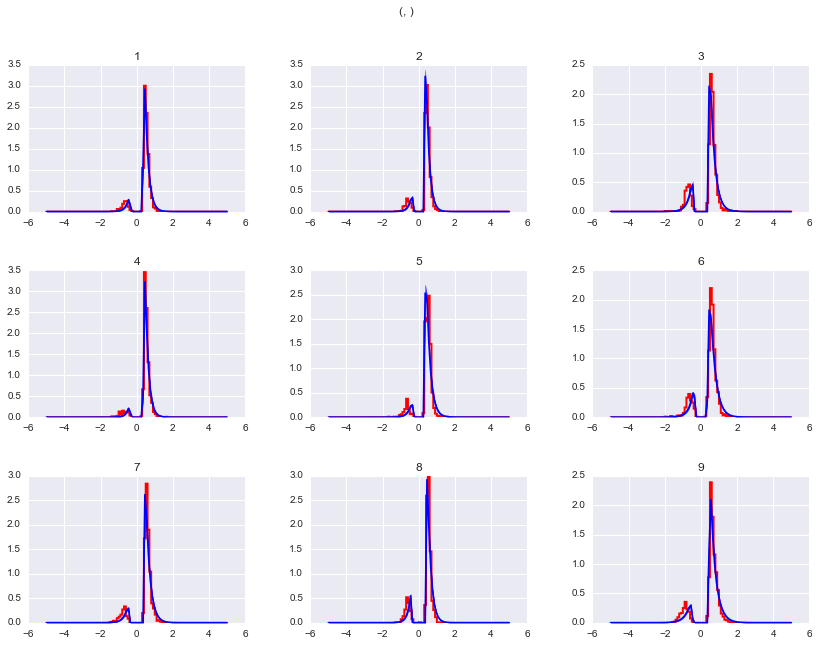

In [112]:
model.plot_posterior_predictive(figsize=(14,10))